This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### ResNet50 /  Classify Multi-label Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
#!pip install ipython-autotime

%load_ext autotime

time: 444 µs (started: 2021-12-07 11:27:47 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.82 ms (started: 2021-12-07 11:27:47 +00:00)


### Load label data.

In [5]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('label/label_multi-label.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv('label/label_multi-label_valid.csv')
label_train = pd.read_csv('label/label_multi-label_train.csv')
label_test = pd.read_csv('label/label_multi-label_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(38817, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 24
TRAIN_DATA_SIZE: 31053
VALID_DATA_SIZE: 3882
TEST_DATA_SIZE: 3882
time: 166 ms (started: 2021-12-07 11:27:47 +00:00)


### Define training pipeline.

In [6]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_train.tfrecords'],
             index_path = ['./tfrecords/multi-label_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 86.1 ms (started: 2021-12-07 11:27:47 +00:00)


### Define validation pipeline.

In [7]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_valid.tfrecords'],
             index_path = ['./tfrecords/multi-label_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.75 ms (started: 2021-12-07 11:27:47 +00:00)


### Fine-tune ResNet50 model for classifying multi-label emotions.

In [8]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/guides/transfer_learning/

if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)

    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 24))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)       

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)      

        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.sigmoid         
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 24
        
        base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(64, 64, 3), # VGG16 expects min 32 x 32
            include_top=False, # Do not include the ImageNet classifier at the top.
            pooling='avg') # average pooling added 
        
        base_model.trainable = True   # Unfreeze ResNet50 weights.

        # See how many layers are in the base model.
        print("Number of layers in the base model: ", len(base_model.layers))
        
        # Fine-tune from this layer onwards.
        fine_tune_at = 120
        
        # Freeze all the layers before the `fine_tune_at` layer.
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False   
            
        inputs = keras.Input(shape=(64, 64, 3))
        x = base_model(inputs)
        fc1 = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer)(x)        
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)          
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1)   
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)  
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          callbacks=[es_callback])

Number of layers in the base model:  176
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 24)                49176     
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 23,637,488
Trainable params: 17,265,264
Non-trainable params: 6,372,224
_________________________________________________________________
Epoch 1/1000
485/485 [==============================] - 25s 40ms/s

485/485 [==============================] - 19s 38ms/step - loss: 0.0920 - accuracy: 0.6308 - val_loss: 0.0974 - val_accuracy: 0.6286
Epoch 50/1000
485/485 [==============================] - 19s 38ms/step - loss: 0.0908 - accuracy: 0.6308 - val_loss: 0.1034 - val_accuracy: 0.5911
Epoch 51/1000
485/485 [==============================] - 18s 38ms/step - loss: 0.0901 - accuracy: 0.6343 - val_loss: 0.1062 - val_accuracy: 0.5807
Epoch 52/1000
485/485 [==============================] - 19s 38ms/step - loss: 0.0887 - accuracy: 0.6413 - val_loss: 0.0898 - val_accuracy: 0.5695
Epoch 53/1000
485/485 [==============================] - 18s 38ms/step - loss: 0.0881 - accuracy: 0.6371 - val_loss: 0.0903 - val_accuracy: 0.6143
Epoch 54/1000
485/485 [==============================] - 18s 38ms/step - loss: 0.0859 - accuracy: 0.6450 - val_loss: 0.1038 - val_accuracy: 0.5612
Epoch 55/1000
485/485 [==============================] - 18s 38ms/step - loss: 0.0860 - accuracy: 0.6461 - val_loss: 0.0900 - val_ac

In [9]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 600 µs (started: 2021-12-07 11:51:44 +00:00)


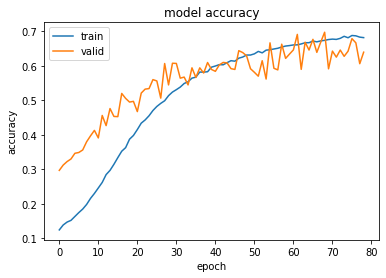

time: 201 ms (started: 2021-12-07 11:51:44 +00:00)


In [10]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

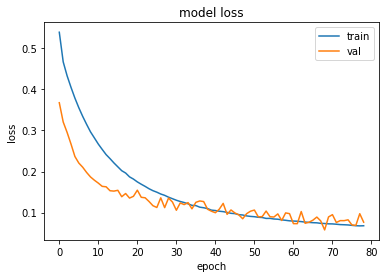

time: 141 ms (started: 2021-12-07 11:51:44 +00:00)


In [11]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [12]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_test.tfrecords'],
             index_path = ['./tfrecords/multi-label_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.85 ms (started: 2021-12-07 11:51:44 +00:00)


### Check test data accuracy.

In [13]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset shapes: ((1, 64, 64, 3), (1, 24)), types: (tf.float32, tf.int64)>
3882/3882 [==============================] - 79s 20ms/step - loss: 0.0560 - accuracy: 0.7002
Test accuracy: 0.7001545429229736
A test output from the last layer: [2.8079210e-03 1.3684896e-04 1.1290014e-05 4.7948095e-03 5.6516649e-03
 5.1911036e-04 8.0456265e-04 6.9303829e-03 1.1281243e-02 5.3536853e-05
 7.0497685e-05 3.2799970e-02 9.0985918e-01 2.6970394e-03 5.6493073e-04
 4.8099100e-03 5.9716762e-03 3.6861477e-04 2.2358587e-03 4.3507785e-05
 3.5091417e-04 4.9580837e-04 3.1448400e-03 5.0320750e-04]
Index of the maximum value: 12
Label: upset
time: 1min 20s (started: 2021-12-07 11:51:44 +00:00)


In [14]:
predictions

array([[2.80792103e-03, 1.36848961e-04, 1.12900143e-05, 4.79480950e-03,
        5.65166492e-03, 5.19110356e-04, 8.04562645e-04, 6.93038292e-03,
        1.12812426e-02, 5.35368526e-05, 7.04976846e-05, 3.27999704e-02,
        9.09859180e-01, 2.69703940e-03, 5.64930728e-04, 4.80990997e-03,
        5.97167620e-03, 3.68614768e-04, 2.23585870e-03, 4.35077854e-05,
        3.50914168e-04, 4.95808374e-04, 3.14484001e-03, 5.03207499e-04],
       [3.50502366e-03, 1.22354727e-03, 2.36885608e-04, 7.61800865e-03,
        1.33674499e-02, 1.69247165e-01, 1.17001124e-03, 5.18594263e-03,
        3.20317820e-02, 2.24225165e-04, 8.56870494e-04, 2.32202217e-01,
        6.48170989e-03, 3.03415488e-03, 1.11003325e-03, 3.26100783e-03,
        3.49375140e-03, 8.48504249e-03, 5.10796579e-03, 1.33573791e-04,
        4.15541115e-04, 8.69195210e-05, 3.18124454e-04, 3.69604939e-04],
       [3.49563779e-03, 4.79182322e-03, 2.71407829e-04, 1.51559478e-02,
        4.17227186e-02, 5.02951117e-03, 2.75714509e-03, 3.0388

time: 4.24 ms (started: 2021-12-07 11:53:04 +00:00)


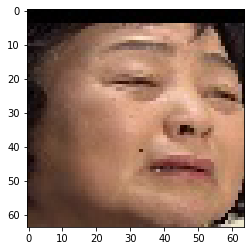

time: 198 ms (started: 2021-12-07 11:53:04 +00:00)


In [15]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [16]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])>

time: 2.63 ms (started: 2021-12-07 11:53:05 +00:00)


### Result: Argmax Accuracy & Micro F1-score

In [18]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

time: 59.4 s (started: 2021-12-07 11:53:05 +00:00)


In [19]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 1.56 s (started: 2021-12-07 11:54:04 +00:00)


In [20]:
true_test.shape

(3882, 24)

time: 2.39 ms (started: 2021-12-07 11:54:06 +00:00)


In [21]:
from sklearn.metrics import accuracy_score, f1_score

true_test_ls = []
pred_test_ls = []

for (true, pred) in zip(true_test, pred_test):
    true_test_ls.append(np.argmax(true))
    pred_test_ls.append(np.argmax(pred))

argmax_acc = accuracy_score(true_test_ls, pred_test_ls)
f1_micro = f1_score(true_test_ls, pred_test_ls, average='micro')

print("argmax accuracy:", argmax_acc)
print("f1_micro:", f1_micro)

argmax accuracy: 0.7001545595054096
f1_micro: 0.7001545595054096
time: 325 ms (started: 2021-12-07 11:54:06 +00:00)


### Result: Threshold=0.5 Accuracy & Micro F1-score

In [23]:
pred_05 = pred_test.copy()
pred_05

array([[2.8079210e-03, 1.3684896e-04, 1.1290014e-05, ..., 4.9580837e-04,
        3.1448400e-03, 5.0320750e-04],
       [3.5050237e-03, 1.2235473e-03, 2.3688561e-04, ..., 8.6919521e-05,
        3.1812445e-04, 3.6960494e-04],
       [3.4956378e-03, 4.7918232e-03, 2.7140783e-04, ..., 7.0560561e-04,
        9.7018359e-03, 4.9643577e-03],
       ...,
       [3.1008008e-03, 1.8239929e-03, 2.1540590e-04, ..., 1.8726942e-05,
        2.8376859e-03, 9.4760139e-04],
       [6.2240107e-04, 8.9555442e-01, 1.3196407e-04, ..., 3.9782738e-03,
        5.1966934e-05, 2.6079027e-03],
       [1.5231204e-04, 7.5336420e-06, 1.0127682e-05, ..., 1.8535071e-06,
        2.5654903e-02, 2.1931835e-06]], dtype=float32)

time: 6.16 ms (started: 2021-12-07 11:54:06 +00:00)


In [24]:
for ls in pred_05:
    thres = 0.5
    pred_05[pred_05 >= thres] = 1
    pred_05[pred_05 < thres] = 0
pred_05[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.25 s (started: 2021-12-07 11:54:06 +00:00)


In [25]:
accuracy_score(true_test, pred_05)

0.6473467284904688

time: 8.85 ms (started: 2021-12-07 11:54:07 +00:00)


In [26]:
f1_score(true_test, pred_05, average='micro')

0.8201723967105915

time: 24.1 ms (started: 2021-12-07 11:54:07 +00:00)


### Result: Threshold=0.4 Accuracy & Micro F1-score

In [28]:
pred_04 = pred_test.copy()
for ls in pred_04:
    thres = 0.4
    pred_04[pred_04 >= thres] = 1
    pred_04[pred_04 < thres] = 0
pred_04[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.29 s (started: 2021-12-07 11:54:07 +00:00)


In [29]:
accuracy_score(true_test, pred_04)

0.7001545595054096

time: 8.71 ms (started: 2021-12-07 11:54:08 +00:00)


In [30]:
f1_score(true_test, pred_04, average='micro')

0.8486185725249424

time: 27.2 ms (started: 2021-12-07 11:54:08 +00:00)


### Result: Threshold=0.3 Accuracy & Micro F1-score

In [32]:
pred_03 = pred_test.copy()
for ls in pred_03:
    thres = 0.3
    pred_03[pred_03 >= thres] = 1
    pred_03[pred_03 < thres] = 0
pred_03[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.34 s (started: 2021-12-07 11:54:09 +00:00)


In [33]:
accuracy_score(true_test, pred_03)

0.73827923750644

time: 8.64 ms (started: 2021-12-07 11:54:10 +00:00)


In [34]:
f1_score(true_test, pred_03, average='micro')

0.8683722654801631

time: 25.2 ms (started: 2021-12-07 11:54:10 +00:00)


### Result: Threshold=0.2 Accuracy & Micro F1-score

In [36]:
pred_02 = pred_test.copy()
for ls in pred_02:
    thres = 0.2
    pred_02[pred_02 >= thres] = 1
    pred_02[pred_02 < thres] = 0
pred_02[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.41 s (started: 2021-12-07 11:54:10 +00:00)


In [37]:
accuracy_score(true_test, pred_02)

0.764554353426069

time: 8.52 ms (started: 2021-12-07 11:54:11 +00:00)


In [38]:
f1_score(true_test, pred_02, average='micro')

0.8757824208763114

time: 25.5 ms (started: 2021-12-07 11:54:11 +00:00)


### Result: Threshold=0.1 Accuracy & Micro F1-score

In [40]:
pred_01 = pred_test.copy()
for ls in pred_01:
    thres = 0.1
    pred_01[pred_01 >= thres] = 1
    pred_01[pred_01 < thres] = 0
pred_01[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.56 s (started: 2021-12-07 11:54:11 +00:00)


In [41]:
accuracy_score(true_test, pred_01)

0.7156105100463679

time: 8.38 ms (started: 2021-12-07 11:54:13 +00:00)


In [42]:
f1_score(true_test, pred_01, average='micro')

0.8400856259414888

time: 25.3 ms (started: 2021-12-07 11:54:13 +00:00)
